In [1]:
# Script to have tactile image BYOL training with multi stepped
# tactile images

# Steps:
# 1 - Method to convert t framed tactile information to image
# 2 - Visualize it
# 3 - Train that with BYOL - apply different augmentations similarly
# 4 - Then freeze / unfreeze the encoder, get representations and predict the next action

In [1]:
import glob
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torchvision.transforms as T 

from abc import ABC
from copy import deepcopy
from torchvision.datasets.folder import default_loader as loader 
from torch.utils import data
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf

In [2]:
def get_all_data(data_path):
    roots = glob.glob(f'{data_path}/demonstration_*')
    roots = sorted(roots)

    pbar = tqdm(total = len(roots))

    tactile_indices, allegro_indices, allegro_action_indices = [], [], []
    tactile_values, allegro_tip_positions, allegro_actions = [], [], []
    for root in roots:
        # Load the indices
        with open(os.path.join(root, 'tactile_indices.pkl'), 'rb') as f:
            tactile_indices += pickle.load(f)
        with open(os.path.join(root, 'allegro_indices.pkl'), 'rb') as f:
            allegro_indices += pickle.load(f)
        with open(os.path.join(root, 'allegro_action_indices.pkl'), 'rb') as f:
            allegro_action_indices += pickle.load(f)

        # Load the data
        with h5py.File(os.path.join(root, 'allegro_fingertip_states.h5'), 'r') as f:
            allegro_tip_positions.append(f['positions'][()])
        with h5py.File(os.path.join(root, 'allegro_commanded_joint_states.h5'), 'r') as f:
            allegro_actions.append(f['positions'][()]) # Positions are to be learned - since this is a position control
        with h5py.File(os.path.join(root, 'touch_sensor_values.h5'), 'r') as f:
            tactile_values.append(f['sensor_values'][()])

        pbar.update(1)

    tactile_data = dict(
        tactile_indices = tactile_indices,
        tactile_values = tactile_values
    )

    allegro_data = dict(
        allegro_indices = allegro_indices,
        allegro_tip_positions = allegro_tip_positions,
        allegro_action_indices = allegro_action_indices,
        allegro_actions = allegro_actions
    )

    pbar.close()

    return tactile_data, allegro_data


In [3]:
tactile_data, allegro_data = get_all_data(data_path='/home/irmak/Workspace/Holo-Bot/extracted_data/joystick_2')


100%|██████████| 61/61 [00:00<00:00, 96.44it/s]


In [4]:
import random
from tactile_learning.utils.visualization import plot_tactile_sensor

# Method to get t frames of tactile information and draw them as a big image
def get_random_t_frames(t, tactile_data):
    random_index = random.randint(0, len(tactile_data['tactile_indices']))
    first_demo, first_tactile_id = tactile_data['tactile_indices'][random_index]
    last_demo, last_tactile_id = tactile_data['tactile_indices'][random_index+t]
    while random_index+t >= len(tactile_data['tactile_indices']) or first_demo != last_demo:
        random_index = random.randint(0, len(tactile_data['tactile_indices']))
        first_demo, _ = tactile_data['tactile_indices'][random_index]
        last_demo, _ = tactile_data['tactile_indices'][random_index+t]

    assert first_demo == last_demo, f'In get_random_t_frames, first_demo ({first_demo}) != last_demo ({last_demo})'

    indices = tactile_data['tactile_indices'][random_index:random_index+t]
    tactile_value_shape = tactile_data['tactile_values'][first_demo][0].shape
    desired_tactile_values = np.zeros((
        t, tactile_value_shape[0], tactile_value_shape[1], tactile_value_shape[2]
    ))
    for i, (demo_id, tactile_id) in enumerate(indices):
        desired_tactile_values[i,:] = tactile_data['tactile_values'][demo_id][tactile_id,:]

    return desired_tactile_values

In [5]:
T = 15
tactile_values = get_random_t_frames(t = T, tactile_data = tactile_data)
tactile_values.shape

(15, 15, 16, 3)

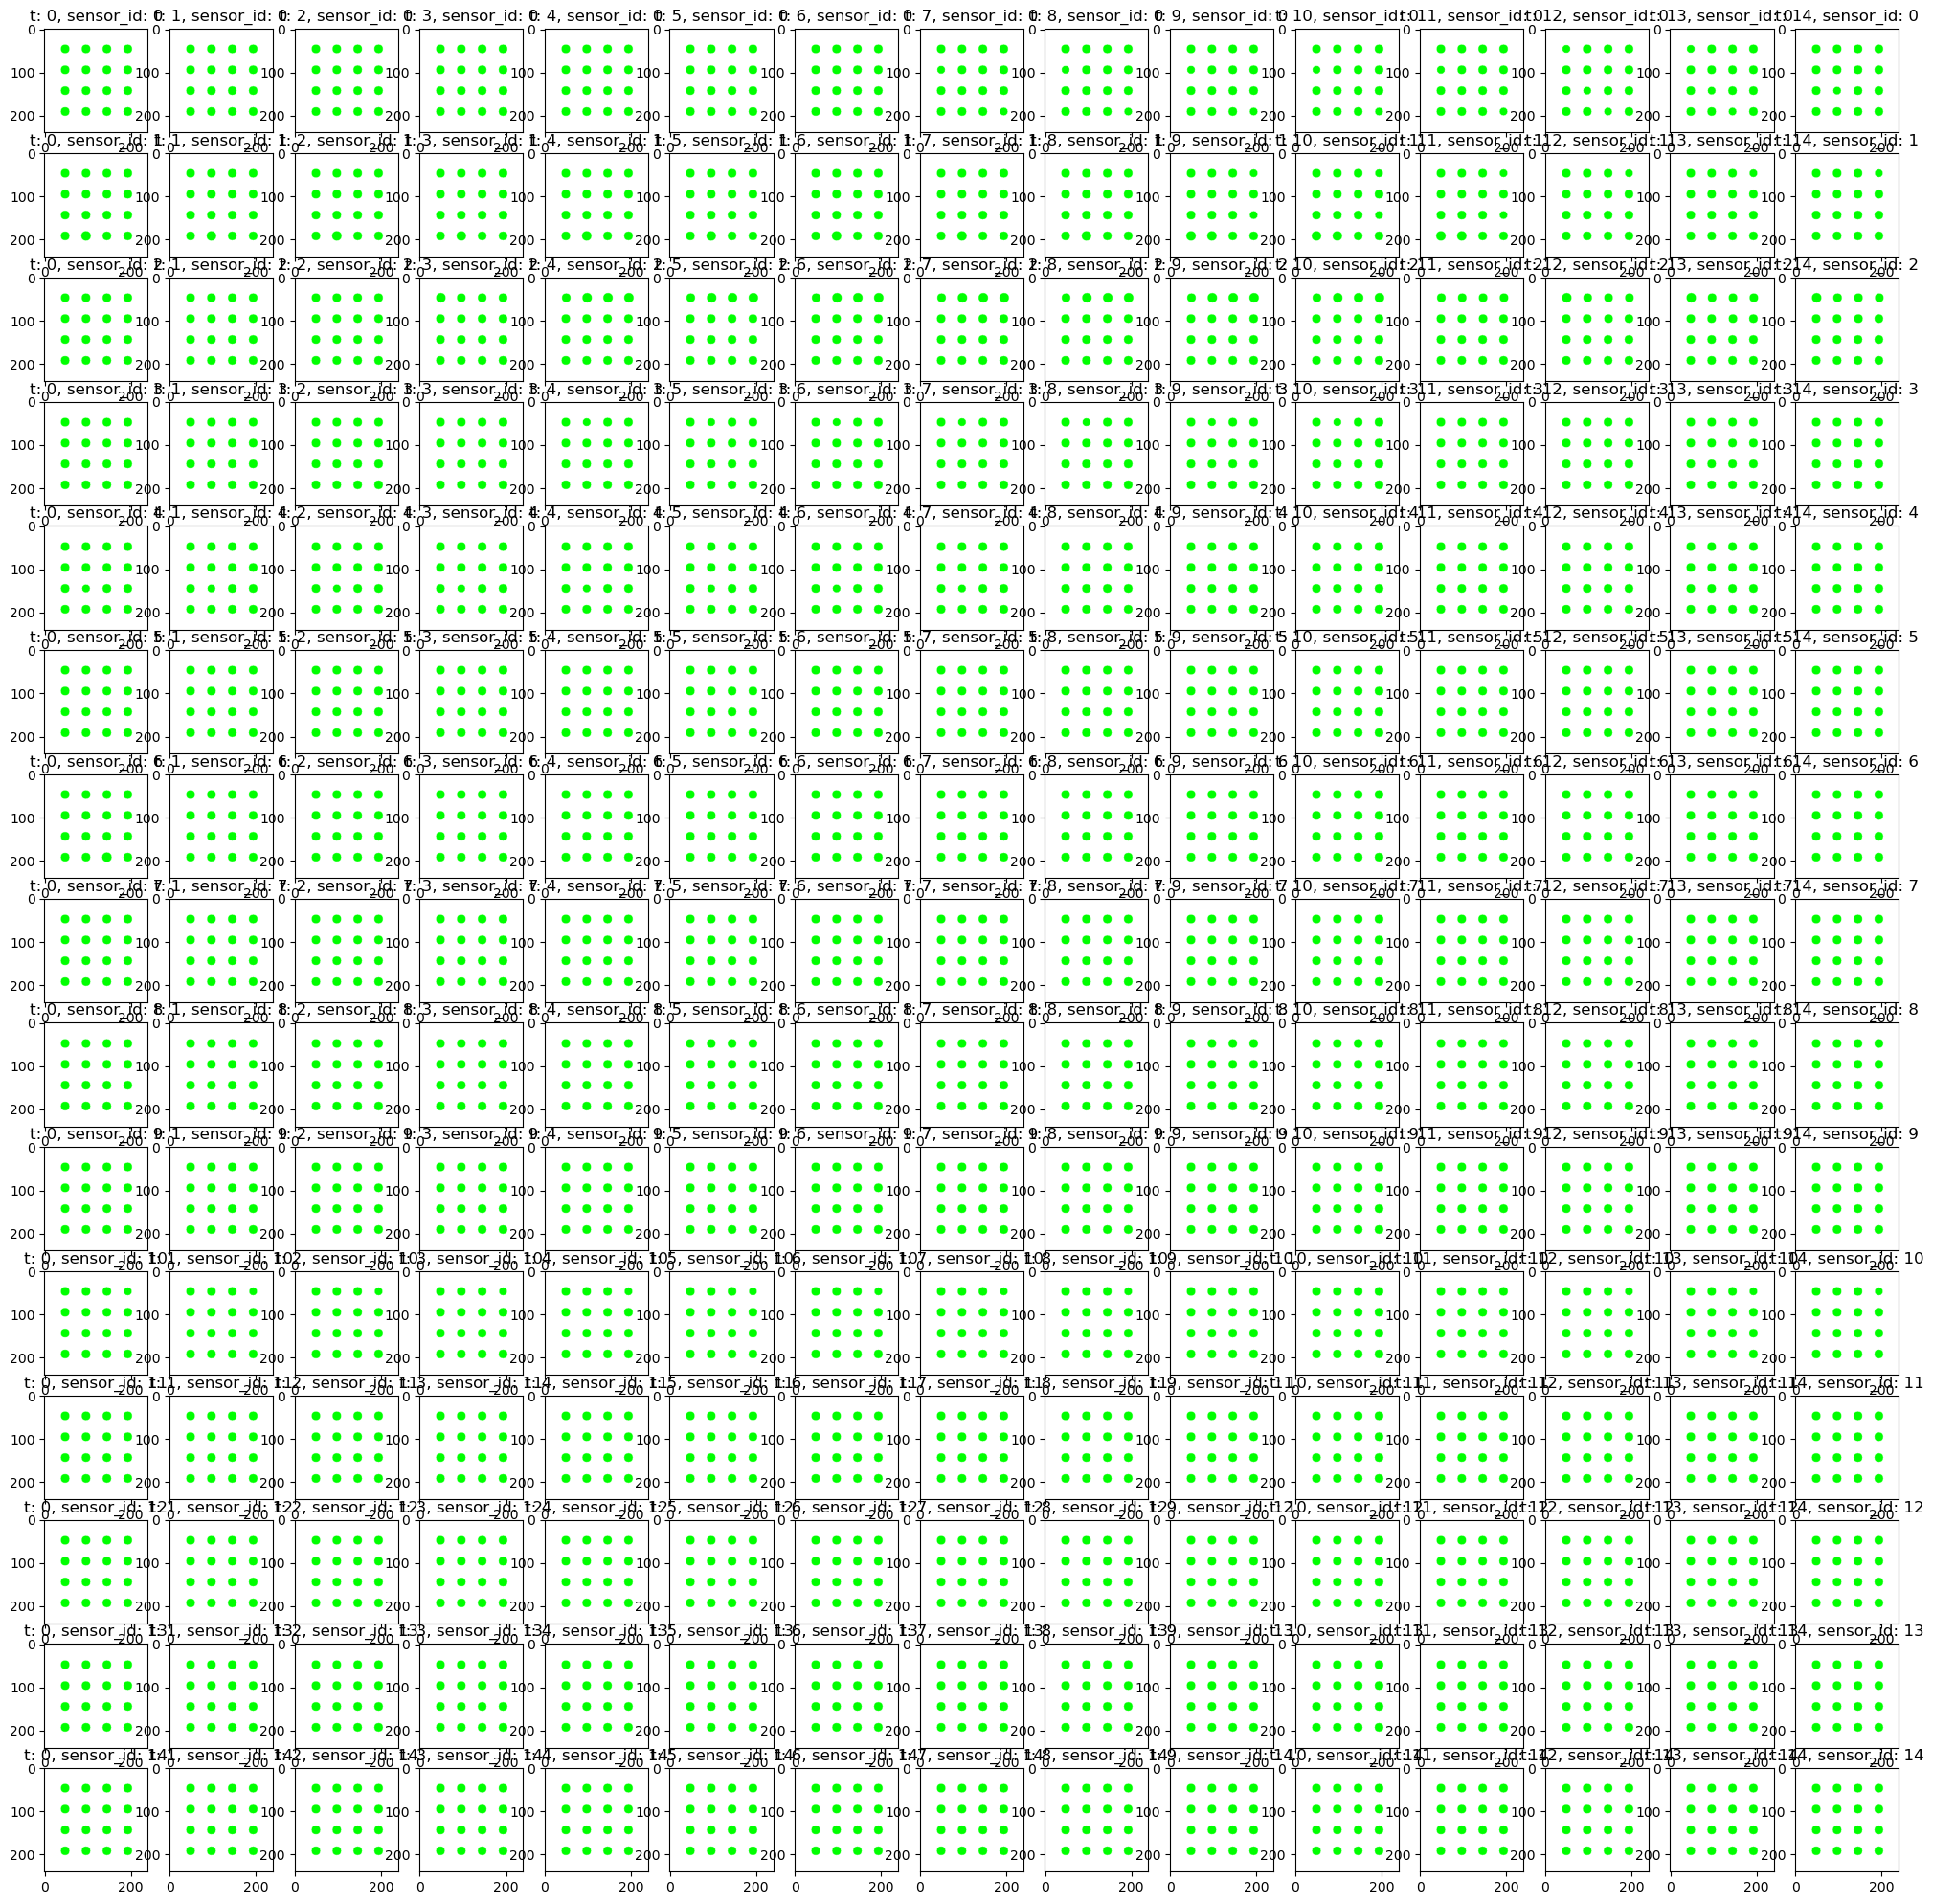

In [6]:
# Script to plot all the framed tactile sensors
fig, axs = plt.subplots(
    nrows = 15, 
    ncols = T,
    figsize=(25,25)
)
for t in range(T):
    for sensor_id in range(15):
        plot_tactile_sensor(
            ax = axs[sensor_id, t], # row, column
            sensor_values = tactile_values[t,sensor_id],
            title = f't: {t}, sensor_id: {sensor_id}'
        )
plt.show()

In [43]:
# Method to convert t tactile value frames to 15xt image
def get_stacked_tactile_image(tactile_values, T):
    reshaped_tactile_value = tactile_values.reshape((T, 15, 4, 4, 3))
    # tactile_image = np.concatenate([reshaped_tactile_value[0,i] for i in range(15)], axis=0)
    tactile_image = np.concatenate([
        np.concatenate([reshaped_tactile_value[j,i,:] for i in range(15)], axis=0) 
        for j in range(T)
    ], axis=1)

    return tactile_image

def plot_tactile_image(tactile_image):
    min, max = tactile_values.min(), tactile_values.max()
    img_range = max - min

    img = (tactile_image - min) / img_range
    img = img.numpy()
    plt.imshow(np.transpose(img, (1,2,0)))

tactile_image = get_stacked_tactile_image(tactile_values, T)
plot_tactile_image(tactile_image)
        


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [44]:
class StackedTactileImage(data.Dataset):
    def __init__(
        self, 
        data_path,
        frame_num = 10, # Number of frames to stack for each image
        fingertip_stats = None
    ):
    
        super().__init__()

        self.roots = glob.glob(f'{data_path}/demonstration_*')
        self.roots = sorted(self.roots)

        # TODO: Maybe add this get_all_data to utils?
        self.tactile_data, self.allegro_data = get_all_data(data_path)
        self.T = frame_num
        # self._length = self._calculate_length()
        self._reprocess_data()

        print('len(self.final_data): {}'.format(len(self.final_data)))
        print('len(tactile_indices): {}'.format(len(self.tactile_data['tactile_indices'])))

    def __len__(self):
        return len(self.final_data)

    def __getitem__(self, index):
        tactile_image = torch.FloatTensor(self.final_data[index]['tactile_image'])
        allegro_action = torch.FloatTensor(self.final_data[index]['allegro_action'])

        # return tactile_image, allegro_action
        # Permute and return the tactile image to a trainable tensor
        tactile_image = torch.permute(tactile_image, (2,0,1)) # TODO: Add allegro_action normalization?
        return tactile_image, allegro_action

    # Method to receive stacked tactile_values such as (T, 15, 16, 3) and return
    # stacked tactile images
    def _get_stacked_image(self, tactile_values):
        T = tactile_values.shape[0]
        reshaped_tactile_value = tactile_values.reshape((T, 15, 4, 4, 3))
        tactile_image = np.concatenate([
            np.concatenate([reshaped_tactile_value[j,i,:] for i in range(15)], axis=0) 
            for j in range(T)
        ], axis=1)

        # Return shape: (T*4, 15*4, 3)
        return tactile_image

    # Method to reprocess the whole tactile_data such that we have stacked image
    # and action applied in the last frame for each frame
    def _reprocess_data(self):
        # Will create a whole dict with all data
        self.final_data = [] # Preprocess data
        print('Reprocessing the data')
        pbar = tqdm(total=len(self.tactile_data['tactile_indices'])-self.T)
        
        for index in range(len(self.tactile_data['tactile_indices'])-self.T):
            indices = self.tactile_data['tactile_indices'][index:index+self.T]
            
            pbar.update(1)
            if indices[0][0] != indices[-1][0]:
                continue # first indices are the demos - demo numbers should be the same

            desired_tactile_values = np.zeros((
                self.T, 15, 16, 3
            ))
            for i, (demo_id, tactile_id) in enumerate(indices):
                desired_tactile_values[i,:] = tactile_data['tactile_values'][demo_id][tactile_id,:]

            # Get the tactile image and the allegro action
            stacked_image = self._get_stacked_image(desired_tactile_values)
            demo_id, allegro_action_id = self.allegro_data['allegro_action_indices'][index+self.T]
            allegro_action = self.allegro_data['allegro_actions'][demo_id][allegro_action_id]

            self.final_data.append(dict(
                tactile_image = stacked_image,
                allegro_action = allegro_action
            ))

        pbar.close()


In [45]:
dset = StackedTactileImage(
    data_path = '/home/irmak/Workspace/Holo-Bot/extracted_data/joystick_2',
    frame_num = 15
)
dataloader = data.DataLoader(dset, batch_size=16, shuffle=True)
batch = next(iter(dataloader))

100%|██████████| 61/61 [00:00<00:00, 123.29it/s]


Reprocessing the data


100%|██████████| 8209/8209 [00:01<00:00, 7033.34it/s]


len(self.final_data): 7421
len(tactile_indices): 8224


In [52]:
def plot_tactile_image(ax, tactile_image):
    min, max = tactile_values.min(), tactile_values.max()
    img_range = max - min
    img = (tactile_image - min) / img_range

    img = img.numpy()
    ax.imshow(np.transpose(img, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])
torch.Size([3, 60, 60]) torch.Size([16])


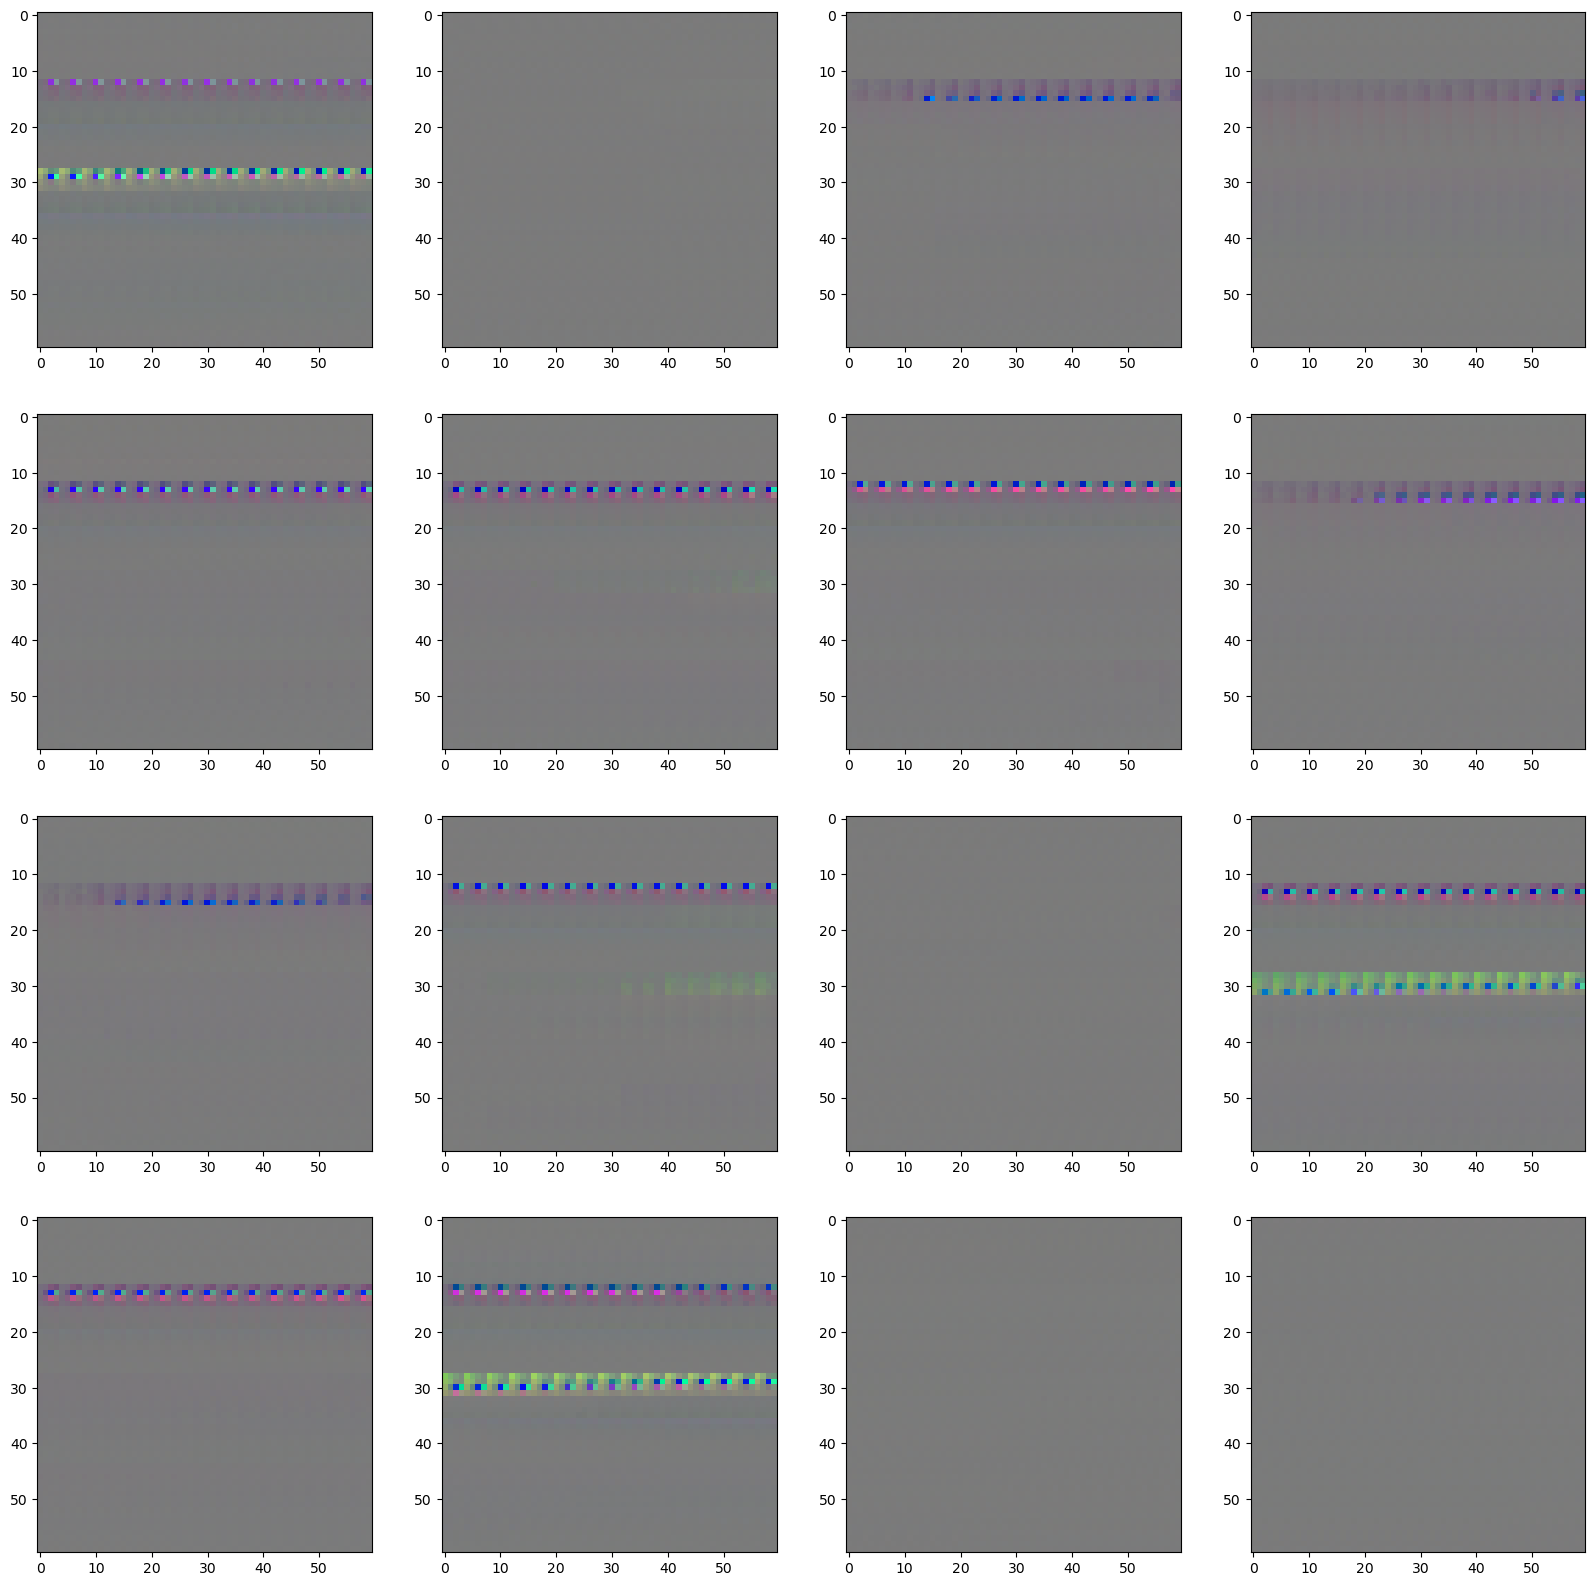

In [53]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        tactile_image, allegro_action = batch[0][i*4+j], batch[1][i*4+j]
        print(tactile_image.shape, allegro_action.shape)
        plot_tactile_image(axs[i,j], tactile_image)

In [56]:
# Training part
from tactile_learning.models.ssl_wrappers.byol import BYOL
from tactile_learning.utils.augmentations import get_tactile_augmentations
from tactile_learning.utils.constants import *
from tactile_learning.models.custom import TactileImageEncoder
from torch.optim import Adam
from torch.utils.data import DataLoader

image_size = 60
augment_fn = get_tactile_augmentations(
    TACTILE_IMAGE_MEANS, 
    TACTILE_IMAGE_STDS,
    img_size=(image_size,image_size)) # One augment_fn is enough (since it will be the same as augment2)

learner = BYOL(
    net = TactileImageEncoder(3, 64), 
    image_size = image_size,
    augment_fn = augment_fn
)
optimizer = Adam(
    learner.parameters(),
    lr = 1e-2,
    weight_decay = 1e-5
)

dataset = StackedTactileImage()
dataloader = DataLoader(
    dataset, 
    batch_size = 32,
    shuffle = True,
    num_workers = 4,
    pin_memory = True,
)

batch = next(iter(dataloader))
print(batch.shape)

def train_one_epoch(learner, dataloader, optimizer):
    learner.train()
    total_train_loss = 0

    for idx, (input_images, _) in enumerate(tqdm(dataloader)):
        
        # input_data = torch.cat(input_images, dim = 1).to(configs.device)

        print(input_images.shape)
        # print('input_images.shap: {}'.format(input_images.shape))
        loss = learner(input_images) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        learner.update_moving_average()

        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(dataloader)
    return average_train_loss 

average_loss = train_one_epoch(learner, dataloader, optimizer)



RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x51984 and 400x64)